In [23]:
import datetime
import calendar
#from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
from HelperFunctions import fnCDOregrid
from importlib import reload
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cartopy.io.shapereader as shpreader

In [24]:
# casper_2020

functions

In [62]:
level_s = np.array([0, 1, 2.5, 5, 7.5, 10, 15, 20,25, 37.5, 50,
         75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 750])

proj = ccrs.PlateCarree()

# James asked for adding county line, Given cartopy's ability to draw shapefiles,
# I download one of those county shapefiles:
# https://prd-tnm.s3.amazonaws.com/StagedProducts/Small-scale/data/Boundaries/countyl010g_shp_nt00964.tar.gz
reader = shpreader.Reader('/glade/work/mingge/SHAPEFILES/COUNTY/countyl010g.shp')

counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

# 
def rd_concat_prism(dataset_s, year_s, year_e,  date_s, date_e, lat_s, lat_e, lon_s, lon_e):
    """
    get Feb. PRISM data 
    dataset_s: 'ppt', 'tmax', 'tmin'
    """
    
    dir_i = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/'

    n_year = year_e - year_s + 1

    for yy in range(n_year):
        year_i = year_s + yy
        year_str = str(year_i)
        date_s = year_str + '-02-01'
        if  calendar.isleap(year_i):
            date_e = year_str + '-02-29'
        else:
            date_e = year_str + '-02-28'

        if dataset_s == 'ppt':
            var_s = 'PR'
            flnm_prism = dir_i + 'PR/PRISM_daily_ppt_' + year_str + '.nc'
        elif dataset_s == 'tmin':
            flnm_prism = dir_i + 'Tmin/PRISM_daily_tmin_' + year_str + '.nc'
        elif dataset_s == 'tmax':
            flnm_prism = dir_i + 'Tmax/PRISM_daily_tmax_' + year_str + '.nc'
          
        print(flnm_prism)    
        with xr.open_dataset(flnm_prism) as ds_prism:
            print(flnm_prism)
            ##### select a range of dates using slice()
            if dataset_s == 'ppt':
                prec_t = ds_prism.PR.sel(time=slice(date_s, date_e),rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e))
            elif dataset_s == 'tmin':
                prec_t = ds_prism.Tmin.sel(time=slice(date_s, date_e),rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e))
            elif dataset_s == 'tmax':
                prec_t = ds_prism.Tmax.sel(time=slice(date_s, date_e),rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e))
            if year_i == year_s:
                prec0_3d = prec_t
                prec = prec_t
            else:
                prec = xr.concat([prec0_3d, prec_t],dim='time')
                prec0_3d = prec 
            
        return prec

def ax_coastlines_country(ax_s):
    ax_s.coastlines(linewidths=0.5)
    ax_s.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))

# plot_prec_4
def plot_prec_4(prec, min_v, max_v, n_lev, cmap_s, colorbar_ori, is_prec):
    # is_prec: use precipitation contour interval
    #fig = plt.figure(figsize=(8,10), dpi=96)
   
    if is_prec=='True':
        ind_max = np.where(level_s==max_v)
        ind_i = int(ind_max[0])
        cnlevel = level_s[:ind_i+1]
    else:
        cnlevel = np.linspace(min_v, max_v, num=n_lev)
  
    for col in range(4):
        ax_s = plt.subplot(2, 2, col+1, projection=proj)
        ax_coastlines_country(ax_s)
        ax_s.add_feature(COUNTIES, facecolor='none', edgecolor='black', linestyle=':')
        mem = col + 1

        im=prec[col].plot.contourf(
            levels=cnlevel,
            cmap=cmap_s,
            ax=ax_s,
            transform=proj,
            add_colorbar=False)

        #if is_prec=='True':
            # use np.datetime_as_string to convert numpy.datetime64 to string obj
        plt.title(np.datetime_as_string(prec.coords['time'].values[col], unit='D'),fontweight="bold", size=15)
        #else:
        #    plt.title(prec.coords['day'][col], unit='D'),fontweight="bold", size=15)     
         
    plt.tight_layout()
    # The position of the bottom edge of the subplots, as a fraction of the figure height.
    #fig.subplots_adjust(bottom=0.15)

    #rect [left, bottom, width, height]
    #cbar_ax = fig.add_axes([0.2, 0.1, 0.7, 0.03])
    #fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
    if colorbar_ori=="vertical":
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.99, 0.1, 0.04, 0.8])
    else:
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.2, 0.001, 0.7, 0.03])
    
    fig.colorbar(im, cax=cbar_ax, orientation=colorbar_ori)
    
    
def plot_prec_8(prec, min_v, max_v, cmap_s, colorbar_ori, is_prec):
    # is_prec: use precipitation contour interval
    if is_prec=='True':
        ind_max = np.where(level_s==max_v)
        ind_i = int(ind_max[0])
        cnlevel = level_s[:ind_i+1]
    else:
        cnlevel = np.linspace(min_v, max_v, num=11)
  
    for col in range(8):
        ax_s = plt.subplot(4, 2, col+1, projection=proj)
        ax_coastlines_country(ax_s)
        ax_s.add_feature(cfeature.STATES, linestyle=':')
        mem = col + 1

        im=prec[col].plot.contourf(
            levels=cnlevel,
            cmap=cmap_s,
            ax=ax_s,
            transform=proj,
            add_colorbar=False)

        #if is_prec=='True':
            # use np.datetime_as_string to convert numpy.datetime64 to string obj
        plt.title(np.datetime_as_string(prec.coords['time'].values[col], unit='D'),fontweight="bold", size=15)
        #else:
        #    plt.title(prec.coords['day'][col], unit='D'),fontweight="bold", size=15)     
         
    plt.tight_layout()
    # The position of the bottom edge of the subplots, as a fraction of the figure height.
    #fig.subplots_adjust(bottom=0.15)

    #rect [left, bottom, width, height]
    #cbar_ax = fig.add_axes([0.2, 0.1, 0.7, 0.03])
    #fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
    if colorbar_ori=="vertical":
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.99, 0.1, 0.04, 0.8])
    else:
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.2, 0.001, 0.7, 0.02])
    
    fig.colorbar(im, cax=cbar_ax, orientation=colorbar_ori)    

Parameters

In [37]:
### Boundrary
date_s = '2021-02-11'
date_e = '2021-02-14'
lat_s = 34.
lat_e = 48.
lon_s = -125.
lon_e = -115.

# latitude longitude coordinates for Portland are: 45°31'24.42"N, 122°40'34.36"W.
lat_s = 42.
lat_e = 48.
lon_s = -124.6
lon_e = -119.6 # -115.

lat_large_s = 20.
lat_large_e = 60.
lon_large_s = -175.
lon_large_e = -60.

#### Prism Precipitation

/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_2021.nc


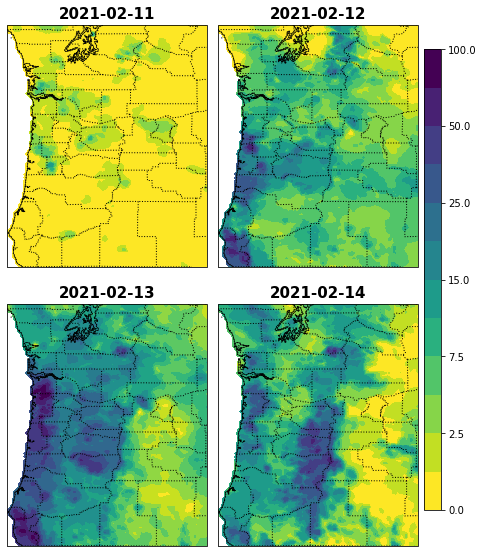

In [42]:
flnm_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_2021.nc'
with xr.open_dataset(flnm_prism ) as ds_prism:
  print(flnm_prism)

##### select a range of dates using slice()
prec_t = ds_prism.PR.sel(time=slice(date_s, date_e),
                         rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e))

fig = plt.figure(figsize=(6,8))
plot_prec_4(prec_t, 1, 100,  'viridis_r', 'vertical', 'True') ## 'YlGnBu') 

#### PRISM Tmax

/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmax/PRISM_daily_tmax_2021.nc


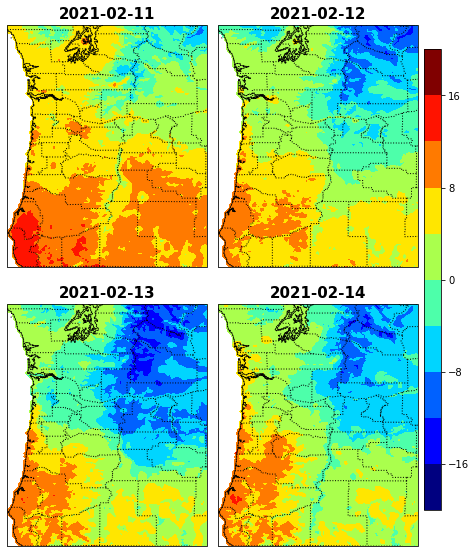

In [45]:
flnm_prism_tmax = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmax/PRISM_daily_tmax_2021.nc'

with xr.open_dataset(flnm_prism_tmax ) as ds_prism_tmax:
  print(flnm_prism_tmax)

tmax_t = ds_prism_tmax.Tmax.sel(time=slice(date_s, date_e),
                         rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e))

fig = plt.figure(figsize=(6,8))
plot_prec_4(tmax_t, -20, 20,  'jet', 'vertical', 'False') ## 'YlGnBu') 

#### PRISM Tmin

/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmin/PRISM_daily_tmin_2021.nc


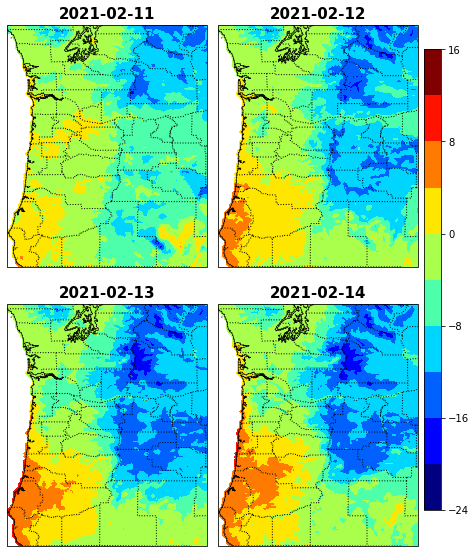

In [48]:
flnm_prism_tmin = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmin/PRISM_daily_tmin_2021.nc'
with xr.open_dataset(flnm_prism_tmin ) as ds_prism_tmin:
  print(flnm_prism_tmin)

tmin_t = ds_prism_tmin.Tmin.sel(time=slice(date_s, date_e),
                         rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e))

fig = plt.figure(figsize=(6,8))
plot_prec_4(tmin_t, -24, 16,  'jet', 'vertical', 'False') ## 'YlGnBu') 

#### Anomalies from the 30-year February average (precip, Tmin, Tmax).
 - Climatology

In [8]:
year_s = 1981
year_e = 2010
#year_e = 1984
prec = rd_concat_prism('ppt', year_s, year_e, date_s, date_e, lat_s, lat_e, lon_s, lon_e)
tmin = rd_concat_prism('tmin', year_s, year_e, date_s, date_e, lat_s, lat_e, lon_s, lon_e)     
tmax = rd_concat_prism('tmax', year_s, year_e, date_s, date_e, lat_s, lat_e, lon_s, lon_e)
prec_cli = prec.mean(dim='time')
tmin_cli = tmin.mean(dim='time')
tmax_cli = tmax.mean(dim='time')

/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_1981.nc
/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_1981.nc
/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmin/PRISM_daily_tmin_1981.nc
/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmin/PRISM_daily_tmin_1981.nc
/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmax/PRISM_daily_tmax_1981.nc
/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmax/PRISM_daily_tmax_1981.nc


 - Precipitation anomaly

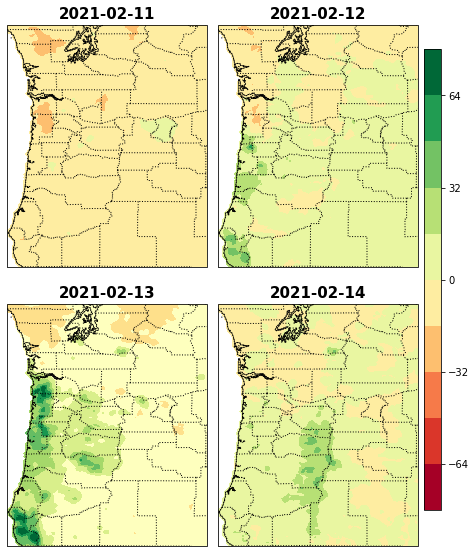

In [63]:
fig = plt.figure(figsize=(6,8))
plot_prec_4(prec_t-prec_cli, -80, 80,  11, 'RdYlGn', 'vertical', 'False')

 - Tmin anomaly

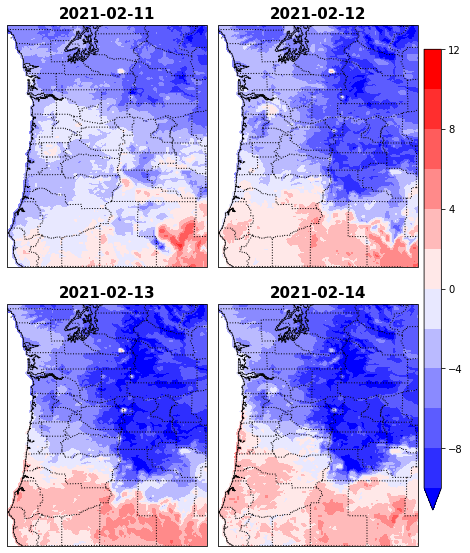

In [64]:
fig = plt.figure(figsize=(6,8))
plot_prec_4(tmin_t-tmin_cli, -10, 12, 12,  'bwr', 'vertical', 'False')

 - Tmax anomaly

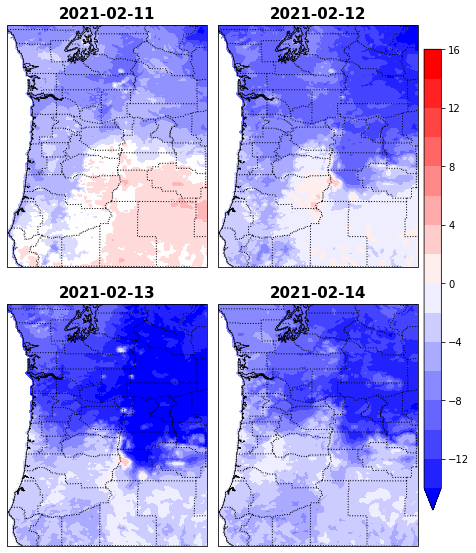

In [82]:
fig = plt.figure(figsize=(6,8))
plot_prec_4(tmax_t-tmax_cli, -14, 16, 16, 'bwr', 'vertical', 'False')

### ERA-I 
- 500 hPa Geopotential  (units = "m**2 s**-2"  12Z)

date_1d = pd.date_range("2021-02-11", periods=4)

for dd in range(11, 15):
    flnm_era5 = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.202102'+str(dd)+'00_202102'+str(dd)+'23.nc'
    print(flnm_era5)
    with xr.open_dataset(flnm_era5 ) as ds_era5:
        z500 = ds_era5.Z[12].sel(level=500, latitude=slice(lat_large_e, lat_large_s), longitude=slice(lon_large_s+360, lon_large_e+360)) #.mean(dim='time')
        del z500['time']
        if (dd==11):
            #expand_dims() modifies ndarray flags to write only, 
            #  to call .copy() on the array after calling expand_dims()
            z500_3d = z500.expand_dims({'time':date_1d}).copy()
                       
        z500_3d[dd-11] = z500         
       
fig = plt.figure(figsize=(10,5))       
       
plot_prec_4(z500_3d, 50000, 60000,  'coolwarm', 'horizontal', 'False') ## 'YlGnBu')


- 500 hPa Geopotential  (units = "m**2 s**-2"  12Z)

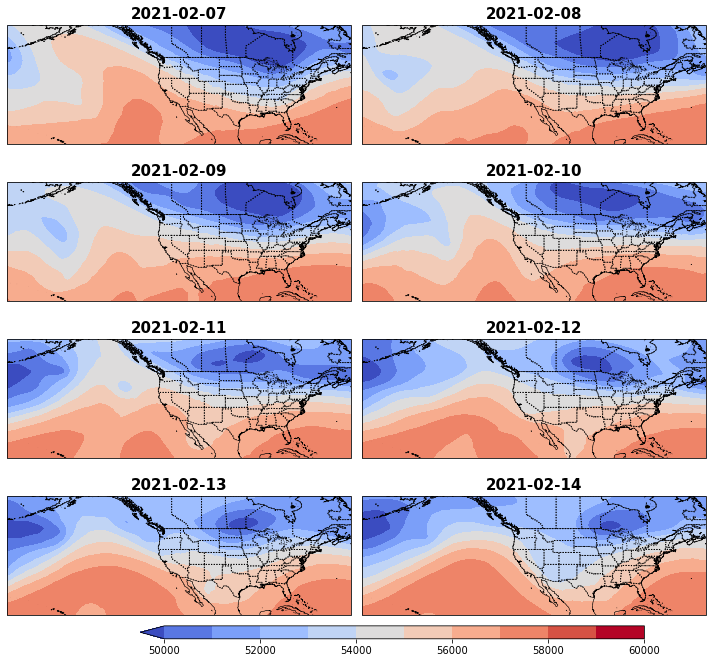

In [83]:
date_1d = pd.date_range("2021-02-07", periods=8)

for dd in range(7, 15):
    # 2 ways to fill the string with leading 0s 1) format string feature. 2) string.zfill() method
    #flnm_era5 = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.202102'+f'{dd:02d}'+'00_202102'+f'{dd:02d}'+'23.nc'
    flnm_era5 = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.202102'+str(dd).zfill(2)+'00_202102'+str(dd).zfill(2)+'23.nc'
    #print(flnm_era5)
    with xr.open_dataset(flnm_era5 ) as ds_era5:
        z500 = ds_era5.Z[12].sel(level=500, latitude=slice(lat_large_e, lat_large_s), longitude=slice(lon_large_s+360, lon_large_e+360)) #.mean(dim='time')
        del z500['time']
        if (dd==7):
            #expand_dims() modifies ndarray flags to write only, 
            #  to call .copy() on the array after calling expand_dims()
            z500_3d = z500.expand_dims({'time':date_1d}).copy()
                       
        z500_3d[dd-7] = z500         
       
fig = plt.figure(figsize=(10,9))       
       
plot_prec_8(z500_3d, 50000, 60000,  'coolwarm', 'horizontal', 'False') ## 'YlGnBu')


- surface pressure.

/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/202102/e5.oper.an.sfc.128_151_msl.ll025sc.2021020100_2021022823.nc


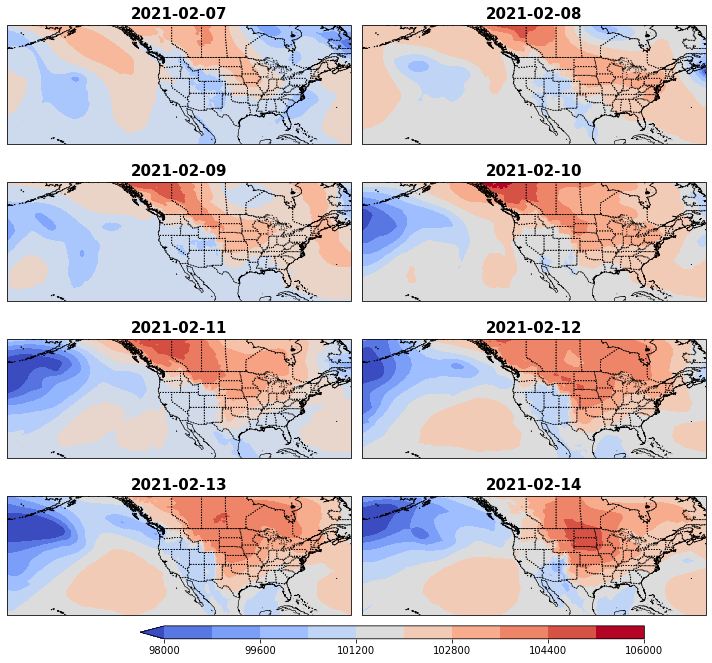

In [13]:
date_1d = pd.date_range(start="2021-02-07",end="2021-02-15",  freq="H")

# chose 12Z data
date_new=date_1d[(date_1d.hour==12)]
date_new

flnm_msl = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/202102/e5.oper.an.sfc.128_151_msl.ll025sc.2021020100_2021022823.nc'
print(flnm_msl)

with xr.open_dataset(flnm_msl) as ds_msl:
    # select specific time and region
    msl = ds_msl.MSL.sel(time=date_new, latitude=slice(lat_large_e, lat_large_s), longitude=slice(lon_large_s+360, lon_large_e+360))
    #print(msl.time)
    
fig = plt.figure(figsize=(10,9))       
       
plot_prec_8(msl, 98000, 106000,  'coolwarm', 'horizontal', 'False')  
    